#### HERE WE DO THE PREPROCESSING AND ANALYSIS OF THE DATASET
#### LIST OF TYPE OF DATASETS THAT WE HAVE CREATED:

1. EWS: the original dataset
2. SPREAD: spread between pair asset that are cointegrated each one
3. STATIONARITY: diffrence between one of the first asset of pair and the linear combiantion with the second asset of the pair between cointegrated pair
4. RESIDUAL: the value that remains after removing the trand and the seasonality for each asset
5. DIFF_TIME: In addition to the current price of the dataset, we also save the difference between the previous and subsequent values ​​(this could be predicted with statistical or machine learning models)

#### Objective of the Code

The goal of this code is to prepare the datasets for training the models in the models.ipynb file. Each processing of the data set is saved in the same Excel from where the original data is taken but saved in a different sheet taking the name of the dataset created.

#### Sequence of preprocessing of the data:

1. The first basic dataset we have is the EWS dataset given to us by Prof Zenti. In this dataset there are labels for supervised classification to identify anomalies and there are various assets also of a different nature from a financial point of view

2. As a first reprocessing of the data we opted for a study to identify which pairs of assets are co-integrated. The study of cointegration allows us to identify which pairs of long-term pairs are equilibrated but can diverge in the short term. We then make the difference between these pairs by calculating the spread, with the idea that if two assets of the same pair diverge a lot per hour it means that in the short term there is an anomaly

3. As a second analysis and procession of the data we thought of adding an extra step compared to the basic cointegration study. So we always study cointegration through a statistical study with acceptance via p_value and then if the pairwise assets are cointegrated we find the parameters in such a way that the two assets are in linear combination with each other so that their difference becomes a stationary process. Here too, stationarity is identified via an acceptance test via p_value

4. Then we also did a statistical study on the individual assets with the aim of finding the seasonality and intrinsic trend of each asset and we save the difference between the value of the asset - seasonality - trend within the dataset and call this difference RESIDUAL

5. Finally, as a final analysis, we also study the trend from a temporal point of view, therefore calculating today's difference with yesterday's price and today's difference with tomorrow's (the value of tomorrow's price could be predicted using other ML algorithms) and the difference between the previous and subsequent prices

#### Main considerations

The idea behind these different studies is to study the same problem with several different points of view with the aim, in some datasets, to find the most stationary time series possible so as to help in the classification of outliers.

Furthermore, each dataset is saved within the same Excel, where the original data is read in the corresponding worksheets. This is done to effectively build a pipeline to help train the models in parallel and also to avoid reprocessing the data every time

In [2]:
# The libraries for data processing are imported
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from tools import seve_hedge_ratio
from statsmodels.tsa.stattools import coint, adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from tools import add_sheet_to_excel, add_data_to_sheet

from statsmodels.tsa.stattools import coint
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import mutual_info_regression
from sklearn.decomposition import PCA

In [3]:
# Step 1: Load the data from the excel file
file_path = './FinancialMarketData.xlsx'
data = pd.read_excel(file_path, sheet_name='EWS')
# Step 2: Separate feature from label so we have in data only data
flag = data['Y'].values
date =  data['Data'].values
data = data.drop(['Data', 'Y'], axis=1)
data = pd.DataFrame(data)
data.head()

,XAU BGNL,ECSURPUS,BDIY,CRY,DXY,JPY,GBP,Cl1,VIX,USGG30YR,...,LP01TREU,EMUSTRUU,LF94TRUU,MXUS,MXEU,MXJP,MXBR,MXRU,MXIN,MXCN
0,283.25,0.077,1388,157.26,100.56,105.86,1.6460,25.77,22.50,6.671,...,116.4635,230.5267,123.7616,1416.12,127.75,990.59,856.76,224.33,217.34,34.30
1,287.65,0.043,1405,165.01,101.86,105.47,1.6383,28.85,21.50,6.747,...,117.2674,231.3770,123.7616,1428.79,129.50,993.98,925.22,234.37,227.08,32.74
2,287.15,0.135,1368,167.24,102.41,106.04,1.6496,28.28,23.02,6.634,...,117.9946,232.3895,123.7616,1385.93,126.48,974.83,886.93,216.82,233.00,32.46
3,282.75,0.191,1311,166.85,104.92,107.85,1.6106,28.22,23.45,6.423,...,120.5100,231.9417,122.3281,1385.31,129.19,1007.12,842.60,201.89,237.48,31.29
4,298.40,0.312,1277,165.43,104.22,109.30,1.6108,28.02,21.25,6.231,...,118.7914,237.8117,122.3281,1411.95,134.67,1034.58,945.15,218.00,258.02,31.32


## Cointegrated variables

In [4]:
# Here the structure of the cointegration matrix is prepared and then 
# subsequently overwritten once the cointegrated pairs have been found

cointegration_matrix = np.zeros((42, 42), dtype=int)
np.fill_diagonal(cointegration_matrix, 1)
cointegration_matrix = pd.DataFrame(cointegration_matrix)

# the name of each asset has been added in the matrix
cointegration_matrix.columns = data.columns
cointegration_matrix.index = data.columns

In [5]:
# cointegration test

cointegrated_pairs = []
diff_stationary_pairs = []
hedge_ratio_all = []
intercept_all = []

# Here we are going to study the cointegration of assets in pairs
for i in range(len(data.columns)):
    for j in range(i + 1, len(data.columns)):
        # cointegration test
        result = coint(data.iloc[:, i], data.iloc[:, j])
        p_value = result[1]

        # if the p_value is less than 0.01 we can reject the null hypothesis of no cointegration
        if p_value < 0.01:

            # insert in the cointegration matrix of that the two assets are cointegrated each other
            cointegrated_pairs.append((data.columns[i], data.columns[j]))
            cointegration_matrix.at[data.columns[i], data.columns[j]] = 1
            cointegration_matrix.at[data.columns[j], data.columns[i]] = 1
            
            S1 = data.iloc[:, i]
            S2 = data.iloc[:, j]

            S1 = sm.add_constant(S1)

            # here we find the linear coefficients so that the difference between S2 and S1 is a stationary process
            model = sm.OLS(S2, S1).fit()

            hedge_ratio = model.params[data.columns[i]]
            hedge_ratio_all.append(hedge_ratio)
            
            intercept = model.params['const']
            # Form the linear combination
            linear_comb = S2 - (hedge_ratio * data.iloc[:, i] + intercept)
            intercept_all.append(intercept)
            # we do the test of stationarity
            pvalue_stationarity = adfuller(linear_comb, autolag='AIC')[1]
            
            # if the p_value is less than 0.01 we can reject the null hypothesis of no stationrity
            if pvalue_stationarity < 0.01:  # Stationarity test p-value threshold
                diff_stationary_pairs.append((data.columns[i], data.columns[j] ,hedge_ratio, intercept, pvalue_stationarity))
                # cointegration_matrix.at[data.columns[i], data.columns[j]] = 0.5
                # cointegration_matrix.at[data.columns[j], data.columns[i]] = 0.5


print("Cointegrated couples", cointegrated_pairs)
print("Number of cointegrated pairs:", len(cointegrated_pairs))
print("Stationary diff pairs:", diff_stationary_pairs)
print("Number of stationary diff pairs:", len(diff_stationary_pairs))


Cointegrated couples [('ECSURPUS', 'BDIY'), ('ECSURPUS', 'CRY'), ('ECSURPUS', 'DXY'), ('ECSURPUS', 'JPY'), ('ECSURPUS', 'GBP'), ('ECSURPUS', 'Cl1'), ('ECSURPUS', 'VIX'), ('ECSURPUS', 'USGG30YR'), ('ECSURPUS', 'GT10'), ('ECSURPUS', 'USGG2YR'), ('ECSURPUS', 'USGG3M'), ('ECSURPUS', 'US0001M'), ('ECSURPUS', 'GTDEM30Y'), ('ECSURPUS', 'GTDEM10Y'), ('ECSURPUS', 'GTDEM2Y'), ('ECSURPUS', 'EONIA'), ('ECSURPUS', 'GTITL30YR'), ('ECSURPUS', 'GTITL10YR'), ('ECSURPUS', 'GTITL2YR'), ('ECSURPUS', 'GTJPY30YR'), ('ECSURPUS', 'GTJPY10YR'), ('ECSURPUS', 'GTJPY2YR'), ('ECSURPUS', 'GTGBP30Y'), ('ECSURPUS', 'GTGBP20Y'), ('ECSURPUS', 'GTGBP2Y'), ('ECSURPUS', 'LUMSTRUU'), ('ECSURPUS', 'LMBITR'), ('ECSURPUS', 'LUACTRUU'), ('ECSURPUS', 'LF98TRUU'), ('ECSURPUS', 'LG30TRUU'), ('ECSURPUS', 'LP01TREU'), ('ECSURPUS', 'EMUSTRUU'), ('ECSURPUS', 'LF94TRUU'), ('ECSURPUS', 'MXUS'), ('ECSURPUS', 'MXEU'), ('ECSURPUS', 'MXJP'), ('ECSURPUS', 'MXBR'), ('ECSURPUS', 'MXRU'), ('ECSURPUS', 'MXIN'), ('ECSURPUS', 'MXCN'), ('VIX', 'US

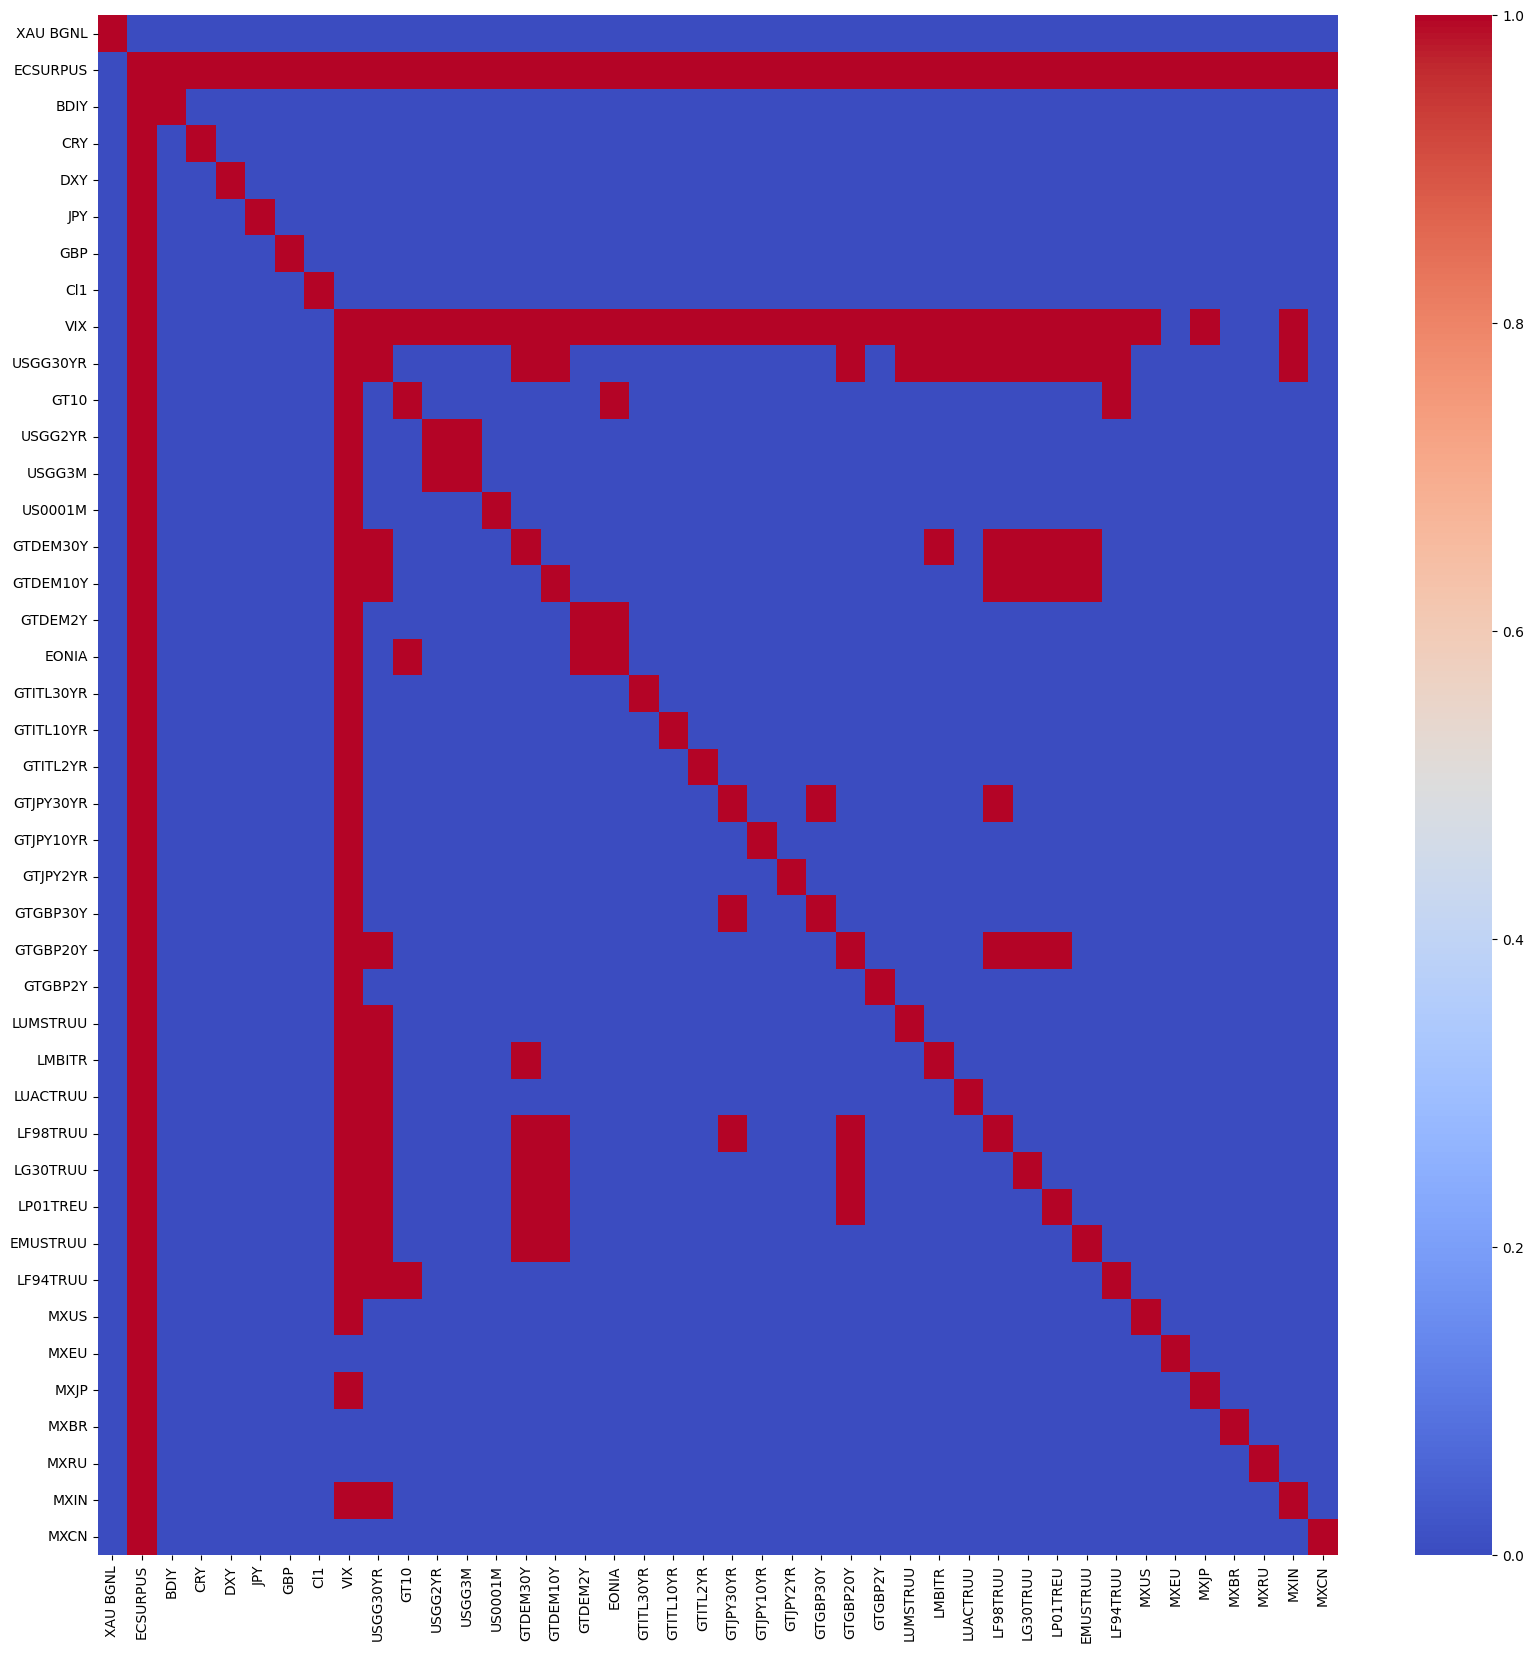

In [6]:
# we plot the cointegration_matrix
# in red are the most cointegrated pairs
plt.figure(figsize=(20, 20))
sns.heatmap(cointegration_matrix, cmap='coolwarm')
plt.show()

In [7]:
# build new data set cointegrated data
# As a new value to save, calculate the spread between the two asset values of only the cointegrated pairs
cointegrated_data = pd.concat([data[col1] - data[col2] for col1, col2 in cointegrated_pairs], axis=1)
cointegrated_data.columns = [f"Coint_{col1}_{col2}" for col1, col2 in cointegrated_pairs]
# The columns Y and Data are added in the dataset
cointegrated_data.insert(0, "Y", flag)
cointegrated_data.insert(1, "Data", date)

# Here new sheet with the name DATA is created
# add_sheet_to_excel(file_path, 'SPREAD')
# Also the new data are stored in the new sheet
# add_data_to_sheet(file_path, 'SPREAD', cointegrated_data)

cointegrated_data.head()

# I save the weights of each column so in case I have new values I can reconstruct the linear combination
seve_hedge_ratio("./settings_models.json", hedge_ratio_all, intercept_all)

# Here we save as a new value the linear combination between the two assets of the cointegrated pair
diff_stationary_data = pd.concat([data[stock2] - (hedge_ratio * data[stock1] + intercept) for stock1, stock2, hedge_ratio, intercept, pvalue_stationarity  in diff_stationary_pairs], axis=1)
diff_stationary_data.columns = [f"Coint_{col1}_{col2}" for col1, col2, hedge_ratio, intercept, pvalue_stationarity in diff_stationary_pairs]
diff_stationary_data.insert(0, "Y", flag)
diff_stationary_data.insert(1, "Data", date)

# The same here we create the new sheet and saved the new dataset
# add_sheet_to_excel(file_path, 'STATIONARITY')
# add_data_to_sheet(file_path, 'STATIONARITY', diff_stationary_data)

diff_stationary_data.head()
    


,Y,Data,Coint_ECSURPUS_VIX,Coint_USGG30YR_GTDEM30Y,Coint_USGG30YR_GTDEM10Y,Coint_USGG30YR_LUMSTRUU,Coint_USGG30YR_LMBITR,Coint_USGG30YR_LUACTRUU,Coint_USGG30YR_LF98TRUU,Coint_USGG30YR_LG30TRUU,...,Coint_GTDEM10Y_LF98TRUU,Coint_GTDEM10Y_LG30TRUU,Coint_GTDEM10Y_LP01TREU,Coint_GTDEM10Y_EMUSTRUU,Coint_GTDEM2Y_EONIA,Coint_GTJPY30YR_GTGBP30Y,Coint_GTJPY30YR_LF98TRUU,Coint_GTGBP20Y_LF98TRUU,Coint_GTGBP20Y_LG30TRUU,Coint_GTGBP20Y_LP01TREU
0,0,1970-01-01 01:00:25.569,2.602915,-0.902793,-1.064697,160.756216,126.347256,438.659945,481.162919,281.943316,...,204.026712,95.725220,61.120310,28.060050,-1.048996,-0.041034,-226.237360,-176.884342,-162.746631,-14.840975
1,0,1970-01-01 01:00:25.569,1.523769,-0.879405,-1.076064,184.650593,140.268006,480.347985,512.889544,303.690577,...,233.282946,115.800202,67.811413,45.626521,-0.913459,0.176520,-229.229485,-98.177725,-110.096709,1.642281
2,0,1970-01-01 01:00:25.569,3.257929,-0.925429,-1.035019,150.899611,117.847816,425.163004,466.201799,272.599603,...,197.210769,91.843944,61.165320,25.703234,-0.747932,0.378663,-332.836480,-125.996496,-128.332070,-3.349410
3,0,1970-01-01 01:00:25.569,3.818286,-0.722111,-0.773502,77.811406,77.448610,308.904235,377.799196,212.719704,...,181.788738,80.878421,60.479910,16.167031,-0.647923,0.165406,-285.436250,-166.174621,-155.596803,-8.936406
4,1,1970-01-01 01:00:25.569,1.899952,-0.539196,-0.461576,14.549295,41.682016,203.764976,297.608249,161.879121,...,189.272072,88.785741,60.075928,25.769768,-0.745055,-0.123230,-185.203506,-175.327150,-158.760204,-12.642530


In [8]:
# Here we load the dataset of STATIONARITY
diff_stationary = pd.read_excel(file_path, sheet_name='STATIONARITY')

# Step 2: Separate feature from label
flag = diff_stationary['Y'].values
diff_stationary_only_data = diff_stationary.drop(['Data', 'Y'], axis=1)
diff_stationary_only_data = pd.DataFrame(diff_stationary_only_data)
diff_stationary_only_data.head()

,Coint_ECSURPUS_VIX,Coint_USGG30YR_GTDEM30Y,Coint_USGG30YR_GTDEM10Y,Coint_USGG30YR_LUMSTRUU,Coint_USGG30YR_LMBITR,Coint_USGG30YR_LUACTRUU,Coint_USGG30YR_LF98TRUU,Coint_USGG30YR_LG30TRUU,Coint_USGG30YR_LP01TREU,Coint_USGG30YR_EMUSTRUU,...,Coint_GTDEM10Y_LF98TRUU,Coint_GTDEM10Y_LG30TRUU,Coint_GTDEM10Y_LP01TREU,Coint_GTDEM10Y_EMUSTRUU,Coint_GTDEM2Y_EONIA,Coint_GTJPY30YR_GTGBP30Y,Coint_GTJPY30YR_LF98TRUU,Coint_GTGBP20Y_LF98TRUU,Coint_GTGBP20Y_LG30TRUU,Coint_GTGBP20Y_LP01TREU
0,2.602915,-0.902793,-1.064697,160.756216,126.347256,438.659945,481.162919,281.943316,111.550374,199.623069,...,204.026712,95.725220,61.120310,28.060050,-1.048996,-0.041034,-226.237360,-176.884342,-162.746631,-14.840975
1,1.523769,-0.879405,-1.076064,184.650593,140.268006,480.347985,512.889544,303.690577,118.604357,219.000391,...,233.282946,115.800202,67.811413,45.626521,-0.913459,0.176520,-229.229485,-98.177725,-110.096709,1.642281
2,3.257929,-0.925429,-1.035019,150.899611,117.847816,425.163004,466.201799,272.599603,110.038671,192.466134,...,197.210769,91.843944,61.165320,25.703234,-0.747932,0.378663,-332.836480,-125.996496,-128.332070,-3.349410
3,3.818286,-0.722111,-0.773502,77.811406,77.448610,308.904235,377.799196,212.719704,95.201866,140.581470,...,181.788738,80.878421,60.479910,16.167031,-0.647923,0.165406,-285.436250,-166.174621,-155.596803,-8.936406
4,1.899952,-0.539196,-0.461576,14.549295,41.682016,203.764976,297.608249,161.879121,77.693582,99.646361,...,189.272072,88.785741,60.075928,25.769768,-0.745055,-0.123230,-185.203506,-175.327150,-158.760204,-12.642530


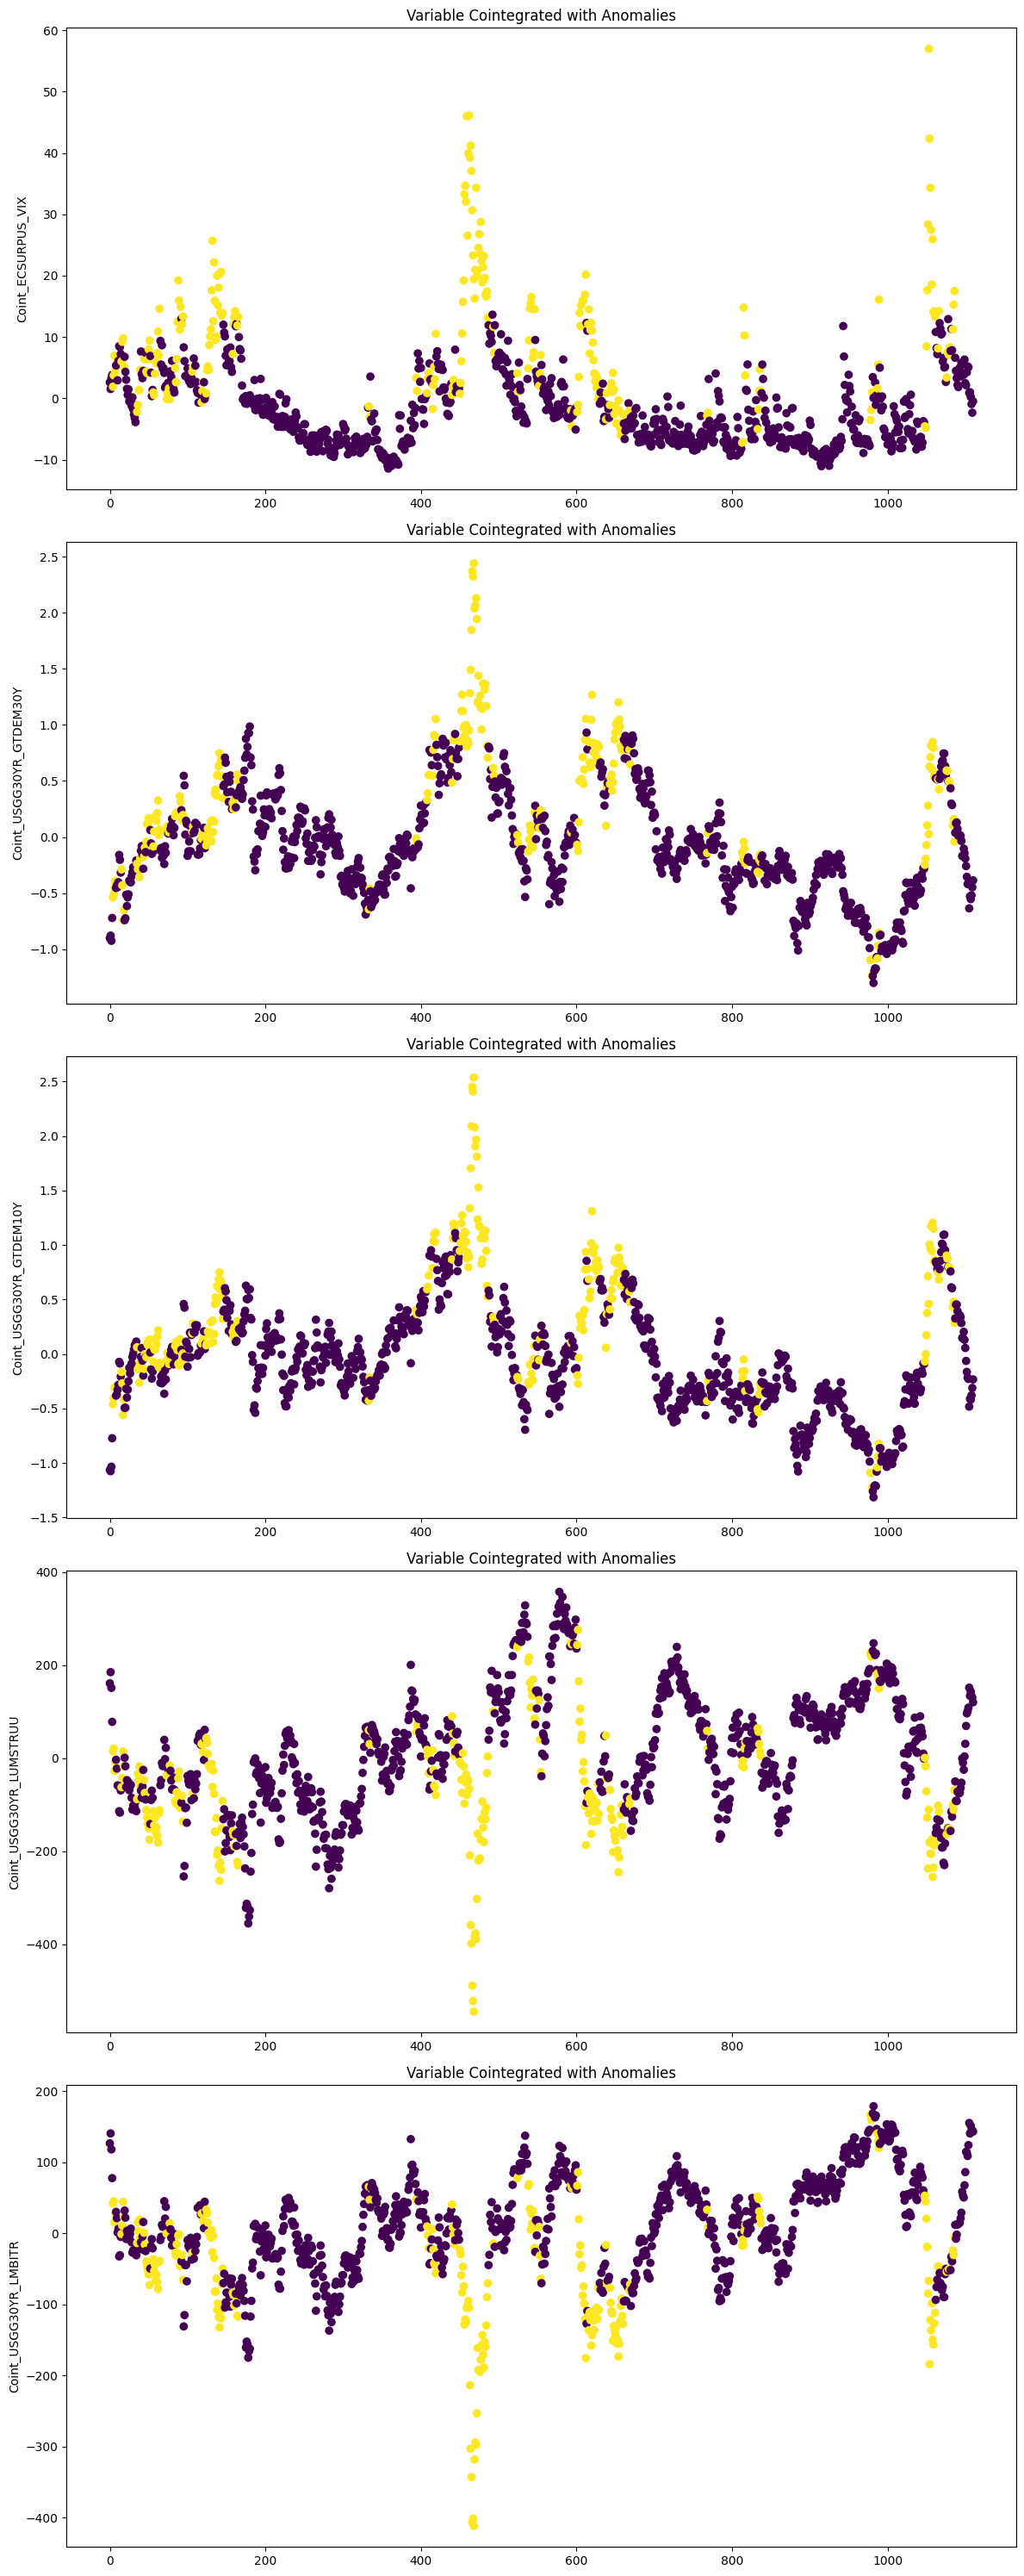

In [9]:
# Now we plot the linear combination between cointegrated variables and you can clearly 
# see from the graphs how we managed to have good stationary series
plt.figure(figsize=(12, 30))

# We plot the first 5 couples
num = 5

for i in range(0, num):
    plt.subplot(num, 1, i+1)
    cointegrated_variable = diff_stationary_only_data.columns[i]
    plt.scatter(range(len(diff_stationary_only_data)), diff_stationary_only_data[cointegrated_variable], c=flag, cmap='viridis')
    plt.title("Variable Cointegrated with Anomalies")
    plt.ylabel(cointegrated_variable)

plt.tight_layout()
plt.show()

# Furthermore, we can already notice by eye that anomalies are found when there is a value 
# of the difference that is furthest from the mean of the stationary time series

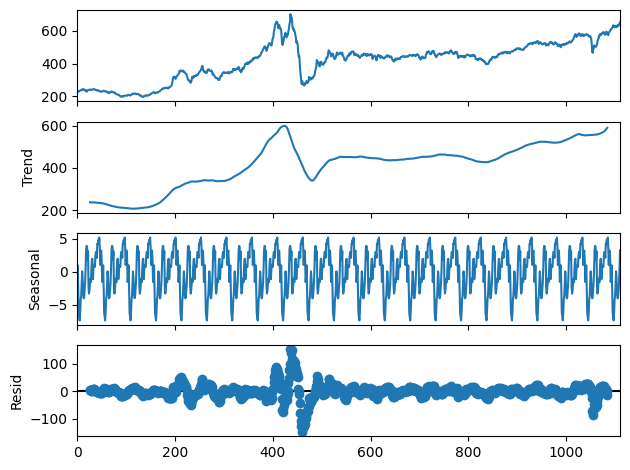

In [10]:
# Here we study the seasonality of the asset

# first of all we study the seasonality and the trend on the average of each column
mean_values = data.mean(axis=1)

# Decomposition of the time series into seasonality, trends and residuals
result = seasonal_decompose(mean_values, model='additive', period=52)

# Viewing results
result.plot()
plt.show()


Augmented Dickey-Fuller test:
Test statistics: -9.858129612338374
P-value: 4.3045064167091566e-17
Critical values:
  1%: -3.436617132314828
  5%: -2.864307097893787
  10%: -2.568243313067353


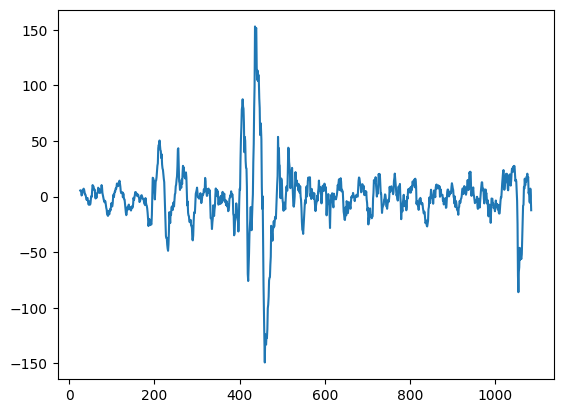

In [11]:
# Here we do the Dickey-Fuller test to understand if the time series is stationary

# we  eliminate the first 26 rows and the last 26 rows because 
# the decomposition needs starting data and to study the trend and seasonality
resid=result.resid[26:-26]
adf_test = adfuller(resid)

print("Augmented Dickey-Fuller test:")
print(f"Test statistics: {adf_test[0]}")
print(f"P-value: {adf_test[1]}")
print("Critical values:")
for key, value in adf_test[4].items():
    print(f"  {key}: {value}")
    
plt.plot(resid) 

In [12]:
residuals_df = pd.DataFrame(index=data.index)

for colonna in data.columns:
    
    # Now we do Time Series Decomposition for each column so we study the individual asset
    result = seasonal_decompose(data[colonna], model='additive', period=52)
    
    # Slice the residuals to remove boundary effects
    resid = result.resid[26:-26]
    
    # Save the residuals in the new DataFrame
    residuals_df[colonna] = resid
    
    # Test di Dickey-Fuller aumentato
    adf_test = adfuller(resid.dropna())  # Drop NaNs for the ADF test



# Remove the first and last 26 rows from the residuals DataFrame
residuals_df = residuals_df.iloc[26:-26]
num = residuals_df.shape[0]
# Add 'Y' and 'Data' columns from the original DataFrame to the residuals DataFrame
insert_column = pd.DataFrame(index=data.index)

insert_column.insert(0, "Y", flag)
insert_column.insert(1, "Data", date)

# we have added the Y and Data columns to the data in order to have a complete dataset
residuals_df = pd.concat([insert_column.iloc[26:-26].reset_index(drop=True), residuals_df.reset_index(drop=True)], axis=1)
# Print the resulting DataFrame
print("Residuals DataFrame after removing boundary rows:")
print(residuals_df)

Residuals DataFrame after removing boundary rows:
      Y                    Data   XAU BGNL  ECSURPUS        BDIY       CRY  \
0     0 1970-01-01 01:00:25.569  19.043320 -0.163477   20.255688 -4.607012   
1     0 1970-01-01 01:00:25.569  14.844245 -0.145759   27.191127  0.342285   
2     0 1970-01-01 01:00:25.569  10.309918 -0.252992   14.856420 -7.949179   
3     0 1970-01-01 01:00:25.569  10.310628 -0.151924   14.040486 -8.639597   
4     0 1970-01-01 01:00:25.569   8.601700 -0.204787  -10.475539 -7.485423   
...  ..                     ...        ...       ...         ...       ...   
1054  1 1970-01-01 01:00:25.569  69.707043  0.242981 -135.464550 -1.657736   
1055  0 1970-01-01 01:00:25.569  66.052634  0.227271   79.493325 -5.378658   
1056  0 1970-01-01 01:00:25.569  78.863682  0.354403  479.854589 -3.049213   
1057  0 1970-01-01 01:00:25.569  62.715358  0.326020   88.546897 -1.333557   
1058  1 1970-01-01 01:00:25.569  71.401970  0.397409 -258.505301 -2.513946   

           DX

In [13]:
# As previous we create the sheet of RESIDUAL and we save the data in that sheet
# add_sheet_to_excel(file_path, 'RESIDUAL')
# add_data_to_sheet(file_path, 'RESIDUAL', residuals_df)

In [14]:
# Here we study the time difference dataset

# Step 1: Load the data
file_path = './FinancialMarketData.xlsx'
df = pd.read_excel(file_path, sheet_name='EWS')

# df['Data'] = pd.to_datetime(df['Data'], format='%d/%m/%Y')
# df = df.sort_values(by='Data')

# REMOVE THE FIRST TWO COLUMN (Y AND DATA)
colonne_da_shiftare = df.columns[2:]
colonne_da_eliminare = []

for colonna in colonne_da_shiftare:
    df.insert(df.columns.get_loc(colonna) + 1, f'{colonna}_Precedente', df[colonna].shift(1))

for colonna in colonne_da_shiftare:
    df.insert(df.columns.get_loc(f'{colonna}_Precedente') + 1, f'{colonna}_Successivo', df[colonna].shift(-1))

for colonna in colonne_da_shiftare:
    df.insert(df.columns.get_loc(colonna) + 1, f'{colonna}_Diff_Prec', df[colonna] - df[f'{colonna}_Precedente'])
    df.insert(df.columns.get_loc(f'{colonna}_Diff_Prec') + 1, f'{colonna}_Diff_Succ', df[f'{colonna}_Successivo'] - df[colonna])
    df.insert(df.columns.get_loc(f'{colonna}_Diff_Succ') + 1, f'{colonna}_Diff_PreSucc', df[f'{colonna}_Successivo'] - df[f'{colonna}_Precedente'])
    

# we eliminate the first and the last value because there are some nan values
df = df.iloc[1:-1]

df.head()
# Here you can notice some warnings that Python writes because 
# we are modifying the datafram by adding columns between the columns. 
# These warnings are not actually errors but only say that the operation is not fully optimized

/var/folders/qz/6n2wjc295md8z9fg3mt4n3nw0000gn/T/ipykernel_4598/2022433515.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.insert(df.columns.get_loc(f'{colonna}_Diff_Prec') + 1, f'{colonna}_Diff_Succ', df[f'{colonna}_Successivo'] - df[colonna])
/var/folders/qz/6n2wjc295md8z9fg3mt4n3nw0000gn/T/ipykernel_4598/2022433515.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.insert(df.columns.get_loc(f'{colonna}_Diff_Succ') + 1, f'{colonna}_Diff_PreSucc', df[f'{colonna}_Successivo'] - df[f'{colonna}_Precedente'])
/var/fold

,Y,Data,XAU BGNL,XAU BGNL_Diff_Prec,XAU BGNL_Diff_Succ,XAU BGNL_Diff_PreSucc,XAU BGNL_Precedente,XAU BGNL_Successivo,ECSURPUS,ECSURPUS_Diff_Prec,...,MXIN_Diff_Succ,MXIN_Diff_PreSucc,MXIN_Precedente,MXIN_Successivo,MXCN,MXCN_Diff_Prec,MXCN_Diff_Succ,MXCN_Diff_PreSucc,MXCN_Precedente,MXCN_Successivo
1,0,1970-01-01 01:00:25.569,287.65,4.40,-0.50,3.90,283.25,287.15,0.043,-0.034,...,5.92,15.66,217.34,233.00,32.74,-1.56,-0.28,-1.84,34.30,32.46
2,0,1970-01-01 01:00:25.569,287.15,-0.50,-4.40,-4.90,287.65,282.75,0.135,0.092,...,4.48,10.40,227.08,237.48,32.46,-0.28,-1.17,-1.45,32.74,31.29
3,0,1970-01-01 01:00:25.569,282.75,-4.40,15.65,11.25,287.15,298.40,0.191,0.056,...,20.54,25.02,233.00,258.02,31.29,-1.17,0.03,-1.14,32.46,31.32
4,1,1970-01-01 01:00:25.569,298.40,15.65,5.50,21.15,282.75,303.90,0.312,0.121,...,30.96,51.50,237.48,288.98,31.32,0.03,-3.66,-3.63,31.29,27.66
5,1,1970-01-01 01:00:25.569,303.90,5.50,1.60,7.10,298.40,305.50,0.391,0.079,...,26.23,57.19,258.02,315.21,27.66,-3.66,0.29,-3.37,31.32,27.95


In [15]:
# As usual we create the  sheet DIFF_1 and the data was saved in that sheet
# add_sheet_to_excel(file_path, 'DIFF_TIME')
# add_data_to_sheet(file_path, 'DIFF_TIME', df)